In [14]:
using LinearAlgebra
using Distributions: Bernoulli
using Plots
pyplot()
using SpecialFunctions: erf
include("./utils.jl")


# CDF of 1D Gaussian
#ϕ(x,μ) = 0.5( 1. + erf((x-μ)))
ϕ(μ,σ) = 0.5( 1. + (erf( μ / (σ * √(2)) )))

# Binary entropy. Epsilons for stability
h(p) = -p*log(p+eps()) - (1-p)*log(1-p + eps())

# Approximate conditional entropy term
C = √((π*log(2)/2))
H(μ,σ) = (C / √(σ + C^2))* exp(-0.5 * (μ^2 / (σ + C^2)))

# BALD objective
BALD(μ,σ) = h(ϕ(μ,sqrt(σ + 1))) - H(μ,σ)
KL(p,q) = p * log(p/q) + (1-p) * log( (1-p)/(1-q))



function kernel(x1,x2,σ,l)
    σ * exp.(-0.5 * (x1 .- x2').^2)
end

function response(x)
    p = exp(-(5-x)^2)
    Float64(rand(Bernoulli(p))) # Somehow crashes if not recast to float
end


function predict(x1,y1,x2,σ,l)
    n = size(x1,1)
    Σ_11 = kernel(x1, x1, σ, l) + I(n) * 0.5
    Σ_22 = kernel(x2, x2, σ, l)
    Σ_12 = kernel(x1, x2, σ, l)

    chol11 = cholesky(Σ_11)
    #chol22 = cholesky(Σ_22)

    # Rasmussen tricks for stability and efficiency
    solved = chol11.U\(chol11.L\Σ_12)

    Σ_pred= Σ_22 - solved' * Σ_12
    μ_pred = solved' * y1
    return μ_pred, Σ_pred
end


function choose_point(x1,y1,x2,σ,l)
    μ_pred,Σ_pred =predict(x1,y1,x2,σ,l)
    -BALD(μ_pred[1],Σ_pred[1]) + KL(ϕ(μ_pred[1],Σ_pred[1]),1-eps()) + h(ϕ(μ_pred[1],Σ_pred[1]))
end

temp = []
xs = []
ids = []
gridman =LinRange(-10,10,1000)
σ = 1.
l = 1.

x1 = 2. .+ randn(1)
y1 = response.(x1)
x2 = x1

1-element Array{Float64,1}:
 1.4059339192451001

In [15]:
# User preference function
p_func(x) = exp(-(5-x)^2)

p_func (generic function with 1 method)

[-10.0]
[-4.4344344344344355]
[6.976976976976977]
[10.0]
[-1.511511511511511]
[4.1941941941941945]
[4.1941941941941945]
[4.114114114114113]
[4.314314314314313]
[4.594594594594595]
[4.794794794794795]
[4.1941941941941945]
[4.094094094094094]
[3.9939939939939944]
[3.913913913913913]
[3.8338338338338325]
[3.8338338338338325]
[3.8338338338338325]
[3.8338338338338325]


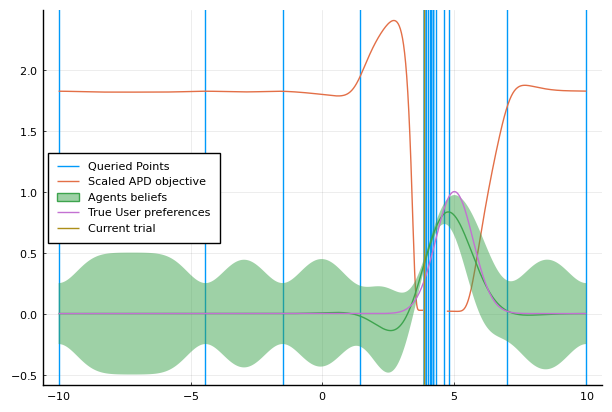

[3.8338338338338325]


Animation("/tmp/jl_1nxz7o", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png", "000020.png"])

In [16]:
anim = @animate for t ∈ 1:20
    σ = 0.5
    l = 1.0

    gridman =LinRange(-10,10,1000)
    
    bro = []
    dudebro = []
    for x_new in gridman
        if x_new != x2
            append!(bro,choose_point(x1,y1,x_new,σ,l))
            append!(dudebro,x_new)
        end
    end
    
    idx = argmin(bro)
    append!(ids,idx)
    
    
    #idx = argmin([choose_point(x1,y1,x2,σ,l) for x2 in gridman])
    x2 = [dudebro[idx]]
    println(x2)

    append!(y1,response(x2[1]))
    append!(x1,x2[1])

    dude = [choose_point(x1,y1,xn,σ,l) for xn in gridman]
    estimated = [predict(x1,y1,xy,σ,l) for xy in gridman]
    Σs = [x[2] for x in estimated]
    μs = [x[1] for x in estimated]

    vline(x1,label="Queried Points")
    plot!(gridman,dude ./ 10 ,label="Scaled APD objective")
    plot!(gridman,μs,ribbon=Σs,label="Agents beliefs")
    plot!(gridman,p_func.(gridman),label="True User preferences")
    vline!([gridman[argmin(dude)]], label="Current trial")
end


┌ Info: Saved animation to 
│   fn = /home/mkoudahl/biaslab/repos/efe_gp/anim.gif
└ @ Plots /home/mkoudahl/.config/julia/packages/Plots/lmp2A/src/animation.jl:104


Plots.AnimatedGif("/home/mkoudahl/biaslab/repos/efe_gp/anim.gif")
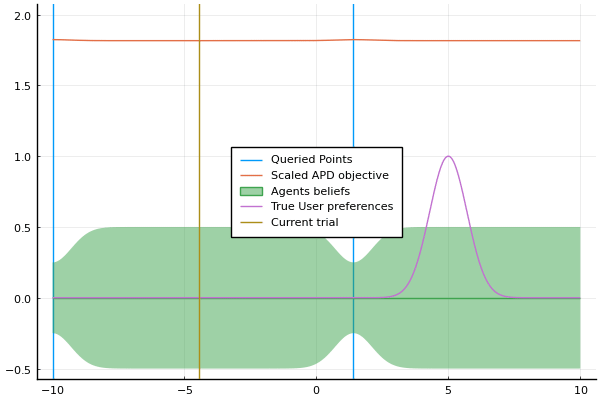

In [17]:
gif(anim, "anim.gif", fps = 2)
